# Argon A-to-Z

This tutorial demonstrates a-to-z how to optimise Lennard Jones parameters for liquid argon, and without going into details. For details see other tutorials and wider MDMC documentation.

In [1]:
# Imports used for this tutorial
import numpy as np
import os
from MDMC.control import Control
from MDMC.MD import Atom, Dispersion, LennardJones, Simulation, Universe, Molecule

In [2]:
# Change the number of threads depending on the number of physical cores on your computer
# as it was tested for LAMMPS
os.environ["OMP_NUM_THREADS"] = "4"

In [3]:
# Build universe with density 0.0176 atoms per AA^-3
density = 0.0176
# This means cubic universe of side:
# 23.0668 A will contain 216 Ar atoms
# 26.911 A will contain 343 Ar atoms
# 30.7553 A will contain 512 Ar atoms
# 38.4441 A will contain 1000 Ar atoms
universe = Universe(dimensions=23.0668)
Ar = Atom('Ar', charge=0., mass=36.0)
# Calculating number of Ar atoms needed to obtain density
n_ar_atoms = int(density * np.product(universe.dimensions))
print(f'Number of argon atoms = {n_ar_atoms}')
universe.fill(Ar, num_struc_units=(n_ar_atoms))

Universe created with:
Dimensions   [23.07, 23.07, 23.07]
Number of argon atoms = 216


In the Jupyter cell above, a box of Argon atoms is set up. However, at this point there is no interaction forces between the argon atoms! In the cell below an appropriate (for argon) force-field interaction potential is defined.

In [4]:
Ar_dispersion = Dispersion(universe,
                           (Ar.atom_type, Ar.atom_type),
                           cutoff=8.,
                           function=LennardJones(epsilon=1.0243, sigma=3.36))

In this case the interaction potential chosen is the humble Lennard Jones (to get info see doc or type `help(LennardJones)`).

Also, a `cutoff` value is chosen (see `help(Dispersion)` for more info). A [rule of thumb for Lennard-Jones](https://en.wikipedia.org/wiki/Lennard-Jones_potential) is to pick `cutoff=2.5*sigma`. The value for argon is recommended to be between 8 and 12 ang. `cutoff` is not a force-field parameter and therefore will not be refined. Ideally, and for any system you want to pick at value of the `cutoff` which is small while not compromising accuracy. For this system picking a value between 8 and 12 ang is found to give near identifical results.

Next (and before starting the refinement), we set up the MD engine and equilibrate the system. Note with MDMC the equilibration only needs to be done once. 

In [5]:
# MD Engine setup
simulation = Simulation(universe,
                        engine="lammps",
                        time_step=10.18893,
                        temperature=120.,
                        traj_step=15)

LAMMPS (29 Sep 2021 - Update 3)
LAMMPS output is captured by PyLammps wrapper
  using 4 OpenMP thread(s) per MPI task
LAMMPS (29 Sep 2021 - Update 3)
LAMMPS output is captured by PyLammps wrapper
  using 4 OpenMP thread(s) per MPI task
Total wall time: 0:00:00
using multi-threaded neighbor list subroutines


Simulation created with lammps engine and settings:
  temperature  120.0



In [6]:
# Energy Minimization and equilibration
simulation.minimize(n_steps=50)
simulation.run(n_steps=10000, equilibration=True)

OK; time to set up the actual refinement of the force-field parameters. 

First we need some data to refine against:

In [7]:
# exp_datasets is a list of dictionaries with one dictionary per experimental
# dataset
# Dataset from: van Well et al. (1985). Physical Review A, 31(5), 3391-3414
# resolution is None as the original author already accounted for instrument resolution
exp_datasets = [{'file_name':'data/Well_s_q_omega_Ar_data.xml',
                 'type':'SQw',
                 'reader':'xml_SQw',
                 'weight':1.,
                 'auto_scale':True,
                 'resolution':800}]

The number of `MD_steps` specified must be large enough to allow for successful calculation of all observables. This depends the `type` of the dataset provided and the value of the `traj_step` (specified when creating the `Simulation`). If a value for `MD_steps` is not provided, then the minimum number needed will be used automatically.

Additionally, some observables will have an upper limit on the number of MD_steps that can be used in calculating their dependent variable(s). In these cases, the number of `MD_steps` is rounded down to a multiple of this upper limit so that we only run steps that will be useful. For example, if we use 1000 `MD_steps` in calculation, but a value of 2500 is provided, then we will run 2000 steps and use this to calculate the variable twice, without wasting time performing an additional 500 steps.

In [8]:
fit_parameters = universe.parameters
fit_parameters['sigma'].constraints = [2.7,3.8]
fit_parameters['epsilon'].constraints = [0.5, 1.5]


control = Control(simulation=simulation,
                  exp_datasets=exp_datasets,
                  fit_parameters=fit_parameters,
                  minimizer_type="GPO",
                  reset_config=True,
                  MD_steps=4000,
                  equilibration_steps=4000)

Control created with:
- Attributes                              -
  Minimizer                             GPO
  FoM type               ChiSquaredExpError
  Number of observables                   1
  Number of parameters                    2



And finally start the refinement! Bump up `n_steps` from 3 when you are ready.

Step         FoM Change state  Pred coords     Pred FoM epsilon (#2)   sigma (#3)


   0       20.06     Accepted [1.0243 kJ / mol, 3.36 Ang]        20.06        1.024         3.36


   1       56.68     Accepted [1.0243 kJ / mol, 3.36 Ang]        20.06        1.044        3.505


   2       523.9     Accepted [1.0243 kJ / mol, 3.36 Ang]        20.06        1.094        2.816


   3       403.4     Accepted [1.0243 kJ / mol, 3.36 Ang]        20.06       0.9195        3.781


   4        76.3     Accepted [1.0243 kJ / mol, 3.36 Ang]        20.06        1.495        3.437


   5       359.3     Accepted [1.0243 kJ / mol, 3.36 Ang]        20.06       0.6487        2.784


   6       84.65     Accepted [1.0243 kJ / mol, 3.36 Ang]        20.06       0.8923        3.138


   7       135.1     Accepted [1.0243 kJ / mol, 3.36 Ang]        20.06       0.7595        3.682


   8       96.12     Accepted [1.0243 kJ / mol, 3.36 Ang]        20.06       0.5177        3.218


   9        1086     Accepted [1.0243 kJ / mol, 3.36 Ang]        20.06        1.217        2.713


  10       26.26     Accepted [1.0243 kJ / mol, 3.36 Ang]        20.06        0.987         3.29


  11       724.6     Accepted [1.0243 kJ / mol, 3.36 Ang]        20.06        1.273        2.882


  12       267.7     Accepted [1.0243 kJ / mol, 3.36 Ang]        20.06       0.6838        2.921


  13       54.99     Accepted [1.0243 kJ / mol, 3.36 Ang]        20.06        0.719        3.543


  14       411.1     Accepted [1.0243 kJ / mol, 3.36 Ang]        20.06        1.176        3.704


  15       43.73     Accepted [1.0243 kJ / mol, 3.36 Ang]        20.06       0.5812          3.6


  16       647.4     Accepted [1.0243 kJ / mol, 3.36 Ang]        20.06        1.442        3.027


  17       262.6     Accepted [1.0243 kJ / mol, 3.36 Ang]        20.06         1.38        3.166


  18       182.2     Accepted [1.0243 kJ / mol, 3.36 Ang]        20.06        1.148        3.034


  19       29.55     Accepted [1.0243 kJ / mol, 3.36 Ang]        20.06        0.847        3.405


  20       26.23     Accepted [1.0243 kJ / mol, 3.36 Ang]        20.06         1.03        3.366


  21       32.73     Accepted [1.0243 kJ / mol, 3.36 Ang]        20.06       0.5013        3.547


  22       19.84     Accepted [0.9543567927739193 kJ / mol, 3.400215063858972 Ang]        19.84       0.9544          3.4


  23       19.75     Accepted [0.9604998602839946 kJ / mol, 3.402535149331591 Ang]        19.75       0.9605        3.403


  24       19.65     Accepted [0.955715505261005 kJ / mol, 3.4024316844170728 Ang]        19.65       0.9557        3.402

The refinement has finished. 
 
Minimum measured point is: 
(0.955715505261005 kJ / mol, 3.4024316844170728 Ang) with an FoM of 19.65412909561144. 
 
Minimum point predicted is: 
(0.955715505261005 kJ / mol, 3.4024316844170728 Ang) for an FoM of 19.65412909561144.
 
 

Automatic Scale Factors
  data/Well_s_q_omega_Ar_data.xml  19.931136


Parameter means = [0.96088214 3.39291896], Parameter errors = [0.0265559  0.02418239]


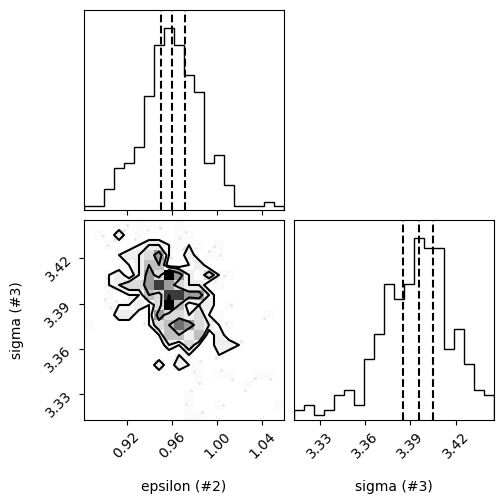

In [9]:
# Run the refinement, i.e. refine the FF parameters against the data
control.refine(n_steps=25)
control.plot_results();